In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import collections
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, StratifiedKFold, cross_val_score

In [43]:
!pip install mord

In [0]:
import mord as m

## Load processed data

In [0]:
train_data = pd.read_csv('train_data_processed.csv')
test_data = pd.read_csv('test_data_processed.csv')
train_labels = np.load('train_labels.csv.npy', allow_pickle=True)
test_labels = np.load('test_labels.csv.npy', allow_pickle=True)

In [0]:
# Explains more than 80% of the variance in the data
pca = PCA(n_components=100)
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
pca_train_genes = pca.fit_transform(train_scaled)

test_scaled = scaler.transform(test_data)
pca_test_genes = pca.transform(test_scaled)

all_weights = pd.DataFrame(pca.components_)
all_weights.columns = train_data.columns.values

### Figure out what this is doing

In [0]:
important_genes = []
for i in range(50):
    important_genes.append([pd.DataFrame(np.abs(all_weights)).T.nlargest(100, i).index.values])
important_genes = np.unique(important_genes, return_counts=False)

In [0]:
important_train = train_data[important_genes]
important_test = test_data[important_genes]

In [0]:
label_mapping = {'WHO II': 0, 'WHO III': 1, 'WHO IV': 2}
reverse_mapping = {0: 'WHO II', 1: 'WHO III', 2: 'WHO IV'}
mapped_labels_train = [label_mapping[x[0]] for x in train_labels]
mapped_labels_test = [label_mapping[x[0]] for x in test_labels]

# Visualize the important genes

In [0]:
def display_pca(input_data, labels, title):
    high_scaler = StandardScaler()
    input_scaled = high_scaler.fit_transform(input_data)
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(input_scaled)
    
    data_df = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
    class_labels_df = pd.DataFrame(labels)
    data_df = pd.concat([data_df, class_labels_df], axis = 1)
    data_df.columns = ['PC1', 'PC2', 'Grade']
    
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1,2,1) 
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    targets = ['WHO II', 'WHO III', 'WHO IV']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data_df['Grade'] == target
        ax.scatter(data_df.loc[indicesToKeep, 'PC1']
                   , data_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

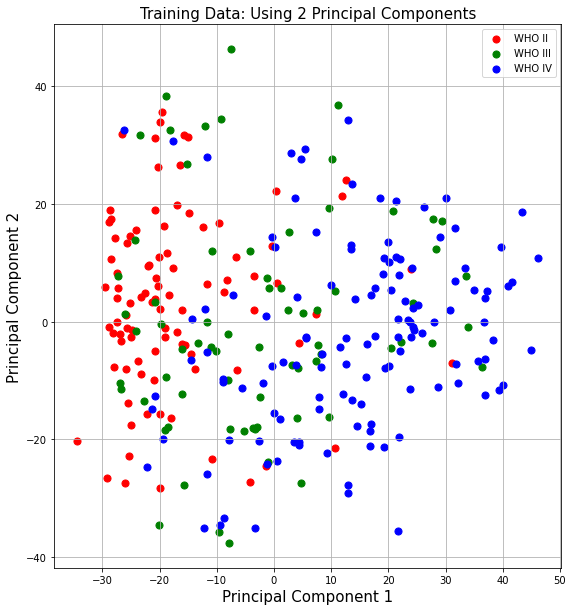

In [150]:
display_pca(important_train, train_labels, 'Training Data: Using 2 Principal Components')

## Standard Random Forest Classifier

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)]
rf = RandomForestClassifier(bootstrap='True', random_state=0, max_features='auto')
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [0]:
rf_params = {'n_estimators': n_estimators, 
             'max_depth': max_depth, 
             'min_samples_split': min_samples_split}

In [0]:
rf_random_search = RandomizedSearchCV(rf, rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)

- Conducted on the 3000+ most important genes

In [141]:
rf_random_search.fit(important_train, mapped_labels_train)
rf_random_search.best_score_

0.688735632183908

In [142]:
rf_random_search.score(important_test, mapped_labels_test)

0.6666666666666666

- Conducted on the top 100 PCs

In [143]:
rf_random_search_pca = RandomizedSearchCV(rf, rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)
rf_random_search_pca.fit(pca_train_genes, mapped_labels_train)
rf_random_search_pca.best_score_

0.661264367816092

In [145]:
rf_random_search_pca.score(pca_test_genes, mapped_labels_test)

0.696969696969697

# Kernel SVM

In [0]:
important_train_scaled = scaler.fit_transform(important_train)
important_test_scaled = scaler.transform(important_test)

- Using 3000+ genes

In [0]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(important_train_scaled, mapped_labels_train)
svc_grid.best_score_

0.6855172413793104

In [0]:
svc_grid.score(important_test_scaled, mapped_labels_test)

0.696969696969697

- Using top 100 PCs

In [146]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(pca_train_genes, mapped_labels_train)
svc_grid.best_score_

0.689080459770115

In [147]:
svc_grid.score(pca_test_genes, mapped_labels_test)

0.696969696969697

## Considering the inherent order present in the classes

## Ordinal Logistic Regression
- AKA ordinal regression
- Predict a value which is ordered and also discrete 
- Seen as a generalization to binary logistic regresion
- Relies on correlated genes being removed
- Multinomial regression doesnt preserve the inherent ranking

- Using 3000 most important genes

In [120]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(important_train_scaled), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6920689655172414

In [156]:
ridge_grid.score(np.array(important_test_scaled), np.array(mapped_labels_test))

0.7272727272727273

- Using top 100 PCs

In [136]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid_pc = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid_pc.fit(np.array(pca_train_genes), np.array(mapped_labels_train))
ridge_grid_pc.best_score_

0.7126436781609196

In [159]:
ridge_grid_pc.score(np.array(pca_test_genes), np.array(mapped_labels_test))

0.7878787878787878

# Small Neural Network
- Combine the two priors together: ordinal classes and overlapping
- http://orca.st.usm.edu/~zwang/files/rank.pdf

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [0]:
def convert_labels(inputs):
    converted = np.zeros((len(inputs), 3))
    for i in range(len(inputs)):
        current_val = inputs[i]
        if current_val == 1:
            converted[i][1] = 1
            converted[i][0] = 1
        elif current_val == 2:
            converted[i][0] = 1
            converted[i][1] = 1
            converted[i][2] = 1
        else:
          converted[i][0] = 1
    return converted

In [0]:
# Convert target variables 
converted_train = convert_labels(mapped_labels_train)
converted_test = convert_labels(mapped_labels_test)

In [0]:
# Convert to tensors
# First only use the PCs
train_tensor = torch.tensor(pca_train_genes.astype(np.float32)) 
test_tensor = torch.tensor(pca_test_genes.astype(np.float32))
train_target_tensor = torch.tensor(converted_train)
test_target_tensor = torch.tensor(converted_test)

In [0]:
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class EntropyLoss(torch.nn.Module):
    def __init__(self):
        super(EntropyLoss, self).__init__()

    def forward(self, model_output, target):
        bc1 = torch.nn.functional.binary_cross_entropy(model_output[:,0], target[:,0])
        bc2 = torch.nn.functional.binary_cross_entropy(model_output[:,1], target[:,1])
        bc3 = torch.nn.functional.binary_cross_entropy(model_output[:,2], target[:,2])
        return bc1 + bc2 + bc3

In [0]:
# Define loss function
# loss_function = torch.nn.NLLLoss()
loss_function = EntropyLoss()
device = torch.device('cuda:0')

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(100, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [183]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 0.3348249357781912
Epoch: 2, Loss: 0.33410287177876424
Epoch: 3, Loss: 0.33337399834080744
Epoch: 4, Loss: 0.33265055598397003
Epoch: 5, Loss: 0.3319225354414237
Epoch: 6, Loss: 0.33119795824352066
Epoch: 7, Loss: 0.3304777623791444
Epoch: 8, Loss: 0.3297580884475457
Epoch: 9, Loss: 0.32903734202447693
Epoch: 10, Loss: 0.3283237042395692
Epoch: 11, Loss: 0.32761142442100927
Epoch: 12, Loss: 0.32689256809259715
Epoch: 13, Loss: 0.32618351947320134
Epoch: 14, Loss: 0.3254771973741682
Epoch: 15, Loss: 0.32476759231404256
Epoch: 16, Loss: 0.3240594675666408
Epoch: 17, Loss: 0.3233538556255792
Epoch: 18, Loss: 0.32264767744039236
Epoch: 19, Loss: 0.32194631546735764
Epoch: 20, Loss: 0.32123897852082
Epoch: 21, Loss: 0.3205375510611032
Epoch: 22, Loss: 0.31983751097792074
Epoch: 23, Loss: 0.31913507337632935
Epoch: 24, Loss: 0.31843497878626775
Epoch: 25, Loss: 0.31773724367744044
Epoch: 26, Loss: 0.31703468020025055
Epoch: 27, Loss: 0.3163428039927232
Epoch: 28, Loss: 0.3156

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())

In [0]:
test_outputs_converted = []
for i in range(len(test_outputs)):
  current = test_outputs[i][0]
  add = [1 if x >= 0.50 else 0 for x in current]
  test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [186]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
  if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
    accuracy += 1
  else:
    missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.8181818181818182


## Feature Analysis on the top performing models

In [0]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

# Permutation Importance

In [0]:
# permutation importance
pi = permutation_importance(ridge_grid.best_estimator_, important_train_scaled, mapped_labels_train, n_repeats=10, random_state=0)
pi_mean_vals = pi['importances_mean']
cols = pd.DataFrame(important_train_scaled).columns
pi_importances_pairs = zip(cols, pi_mean_vals)
pi_pairs_sorted = sorted(pi_importances_pairs, key=lambda x: x[1], reverse=True)

In [0]:
# Get all the non-zero importance genes
non_zero_pi = [x[0] for x in pi_pairs_sorted if x[1] > 0]

# Recursive Feature Elimination

In [0]:
#rfe
selector = RFE(ridge_grid.best_estimator_, 1, step=1)
selector = selector.fit(important_train_scaled, mapped_labels_train)
ranking_pairs = zip(pd.DataFrame(important_train_scaled).columns, selector.ranking_)
ranking_pairs_sorted = sorted(ranking_pairs, key=lambda x: x[1])

In [0]:
top_100_rfe = []
for i in range(100):
  top_100_rfe.append(ranking_pairs_sorted[i][0])

# Rerunning the top models using identified features 

In [0]:
important_genes_pi_train = pd.DataFrame(important_train_scaled)[non_zero_pi]
important_genes_pi_test = pd.DataFrame(important_test_scaled)[non_zero_pi]
important_genes_rfe_train = pd.DataFrame(important_train_scaled)[top_100_rfe]
important_genes_rfe_test = pd.DataFrame(important_test_scaled)[top_100_rfe]

In [242]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(important_genes_pi_train), np.array(mapped_labels_train))
ridge_grid.best_score_

0.7503448275862069

In [243]:
ridge_grid.score(np.array(important_genes_pi_test), np.array(mapped_labels_test))

0.7272727272727273

In [261]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(important_genes_rfe_train), np.array(mapped_labels_train))
ridge_grid.best_score_

0.8597701149425288

In [262]:
ridge_grid.score(np.array(important_genes_rfe_test), np.array(mapped_labels_test))

0.7878787878787878

# Retrain Neural Network

# NOTE: This is on the RFE ones, maybe do it on PI as well?

In [0]:
train_tensor = torch.tensor(important_genes_rfe_train.values.astype(np.float32)) 
test_tensor = torch.tensor(important_genes_rfe_test.values.astype(np.float32))
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(important_genes_rfe_train.columns), 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [305]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 2.0757108989514803
Epoch: 2, Loss: 2.0717079639434814
Epoch: 3, Loss: 2.0677985894052604
Epoch: 4, Loss: 2.0639085142236007
Epoch: 5, Loss: 2.060035366761057
Epoch: 6, Loss: 2.056169949079815
Epoch: 7, Loss: 2.052313101919074
Epoch: 8, Loss: 2.0484586263957776
Epoch: 9, Loss: 2.04461101481789
Epoch: 10, Loss: 2.040764645526284
Epoch: 11, Loss: 2.036909718262522
Epoch: 12, Loss: 2.033042882618151
Epoch: 13, Loss: 2.029167708597685
Epoch: 14, Loss: 2.0252770310954045
Epoch: 15, Loss: 2.021361225529721
Epoch: 16, Loss: 2.0174418248628316
Epoch: 17, Loss: 2.0135178691462468
Epoch: 18, Loss: 2.0095832912545455
Epoch: 19, Loss: 2.0056339439592863
Epoch: 20, Loss: 2.0016687167318246
Epoch: 21, Loss: 1.9976945676301654
Epoch: 22, Loss: 1.993718605292471
Epoch: 23, Loss: 1.9897354778490568
Epoch: 24, Loss: 1.985734920752676
Epoch: 25, Loss: 1.9817234654175608
Epoch: 26, Loss: 1.9777027933221114
Epoch: 27, Loss: 1.9736679227728593
Epoch: 28, Loss: 1.9696210183595355
Epoch: 29, Lo

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())

In [0]:
test_outputs_converted = []
for i in range(len(test_outputs)):
  current = test_outputs[i][0]
  add = [1 if x >= 0.50 else 0 for x in current]
  test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [308]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
  if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
    accuracy += 1
  else:
    missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.8181818181818182


# Exploring other feature selection/reduction techniques

# Sparse PCA: PCA with L1 Regularization

In [0]:
n = 2
sparse_pca = MiniBatchSparsePCA(n_components = n).fit(train_scaled)
sparse_train_genes = sparse_pca.transform(train_scaled)
sparse_test_genes = sparse_pca.transform(test_scaled)

# Evaluate the best model on these genes

In [25]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(sparse_train_genes), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6578160919540229

In [26]:
ridge_grid.score(np.array(sparse_test_genes), np.array(mapped_labels_test))

0.696969696969697

Using the genes determined to be the most important by Sparse PCA

In [64]:
all_weights = pd.DataFrame(sparse_pca.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.014237,0.014525,0.00199,0.020130,0.010377,0.005744,-0.006668,0.0,0.002141,0.001930,0.013758,0.019174,0.014932,0.019306,0.012858,0.007495,0.002698,0.013339,0.002816,0.013898,-0.001266,0.012467,0.0,0.000000,-0.000850,0.006700,0.011132,0.004317,0.00000,0.010167,0.009958,0.015693,0.003509,-0.004169,0.000000,-0.003233,0.000000,0.019874,0.019304,0.000000,...,-0.019547,-0.020863,-0.017228,-0.019651,-0.020818,-0.020224,-0.023864,0.002875,-0.000700,-0.005823,0.000463,-0.00586,-0.009581,0.007015,-0.003814,0.001552,0.000000,-0.019958,-0.005933,-0.014645,-0.009262,-0.017239,-0.011472,-0.023766,-0.005172,0.018053,-0.002095,-0.007080,0.018804,0.000000,-0.000664,0.004101,0.006252,-0.017616,-0.011084,-0.011202,0.003456,-0.005465,-0.015299,0.006110
1,-0.000947,-0.011221,0.01426,-0.000054,0.006500,0.021122,0.019346,0.0,-0.006068,0.013138,0.017092,0.000641,0.000000,0.000000,0.002615,0.013102,-0.013427,0.000972,-0.016135,-0.017367,0.000201,0.001813,0.0,0.001493,0.019441,0.005754,-0.013633,0.006786,0.01392,0.013473,0.010995,0.013328,0.018895,0.011532,0.017061,0.000000,0.018791,0.014257,-0.007448,0.002605,...,0.000260,-0.006384,-0.001957,-0.000335,0.006478,0.000000,0.006323,-0.001113,0.010388,0.006236,-0.003752,0.00758,0.009606,0.000000,-0.009211,0.000000,0.006439,0.001636,0.012746,-0.003252,0.001231,0.000000,-0.013623,-0.010305,0.008567,-0.006604,0.002302,0.003704,-0.001734,0.002966,0.010434,0.000000,0.009776,0.004584,-0.014265,0.010494,0.000000,-0.016129,-0.017821,-0.020634


In [0]:
sparse_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(n):
    sparse_important_genes.extend(temp.nlargest(100, i).index.values)
important_genes = np.unique(sparse_important_genes)

In [0]:
sparse_important_train = train_data[sparse_important_genes]
sparse_important_test = test_data[sparse_important_genes]

In [142]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid_sparse = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid_sparse.fit(np.array(sparse_important_train), np.array(mapped_labels_train))
ridge_grid_sparse.best_score_

0.6718390804597701

In [31]:
ridge_grid.score(np.array(sparse_important_test), np.array(mapped_labels_test))

0.7575757575757576

# Feature selection on the sparse

In [0]:
pi = permutation_importance(ridge_grid_sparse.best_estimator_, sparse_important_train, mapped_labels_train, n_repeats=10, random_state=0)
pi_mean_vals = pi['importances_mean']
cols = pd.DataFrame(sparse_important_train).columns
pi_importances_pairs = zip(cols, pi_mean_vals)
pi_pairs_sorted = sorted(pi_importances_pairs, key=lambda x: x[1], reverse=True)

In [0]:
non_zero_sparse = [int(x[0]) for x in pi_pairs_sorted if x[1] > 0]

In [0]:
selector = RFE(ridge_grid_sparse.best_estimator_, 1, step=1)
selector = selector.fit(sparse_important_train, mapped_labels_train)
ranking_pairs = zip(pd.DataFrame(sparse_important_train).columns, selector.ranking_)
ranking_pairs_sorted = sorted(ranking_pairs, key=lambda x: x[1])

In [0]:
top_100_rfe_sparse = []
for i in range(100):
  top_100_rfe_sparse.append(int(ranking_pairs_sorted[i][0]))

# Neural Network for sparse PCA

In [0]:
train_target_tensor = torch.tensor(converted_train)
test_target_tensor = torch.tensor(converted_test)

In [0]:
train_tensor = torch.tensor(sparse_important_train.values.astype(np.float32)) 
test_tensor = torch.tensor(sparse_important_test.values.astype(np.float32))
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(sparse_important_train.columns), 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [95]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 2.085032394057826
Epoch: 2, Loss: 2.0490491954903853
Epoch: 3, Loss: 2.0117379803406563
Epoch: 4, Loss: 1.9732023979488171
Epoch: 5, Loss: 1.934707854923449
Epoch: 6, Loss: 1.8973391495252911
Epoch: 7, Loss: 1.8607337412081266
Epoch: 8, Loss: 1.8239907277257819
Epoch: 9, Loss: 1.7876568279768292
Epoch: 10, Loss: 1.7524298366747404
Epoch: 11, Loss: 1.7185349025224383
Epoch: 12, Loss: 1.6869918296211643
Epoch: 13, Loss: 1.6579956631911428
Epoch: 14, Loss: 1.6310610582954006
Epoch: 15, Loss: 1.6061146886725175
Epoch: 16, Loss: 1.5831599110051204
Epoch: 17, Loss: 1.5619800467240184
Epoch: 18, Loss: 1.5422855050940263
Epoch: 19, Loss: 1.5239977334675037
Epoch: 20, Loss: 1.5069608249162372
Epoch: 21, Loss: 1.4910249647341276
Epoch: 22, Loss: 1.4760495737979287
Epoch: 23, Loss: 1.461932383085552
Epoch: 24, Loss: 1.4485766887664795
Epoch: 25, Loss: 1.4359307791057385
Epoch: 26, Loss: 1.4238866693095158
Epoch: 27, Loss: 1.4124288182509572
Epoch: 28, Loss: 1.4016022180256091
Epoc

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())

In [0]:
test_outputs_converted = []
for i in range(len(test_outputs)):
  current = test_outputs[i][0]
  add = [1 if x >= 0.50 else 0 for x in current]
  test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [98]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
  if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
    accuracy += 1
  else:
    missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.7272727272727273


# Factor Analysis

In [0]:
from sklearn.decomposition import FactorAnalysis

In [0]:
factors = FactorAnalysis(n_components = 100, copy = True, random_state = 15)
fa_train_genes = factors.fit_transform(train_data)
fa_test_genes = factors.transform(test_data)

In [0]:
all_weights = pd.DataFrame(factors.components_)
col_names = train_data.columns.values
all_weights.columns = col_names

In [0]:
fa_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    fa_important_genes.extend(temp.nlargest(100, i).index.values)
fa_important_genes = np.unique(fa_important_genes)
fa_important_train = train_data[fa_important_genes]
fa_important_test = test_data[fa_important_genes]

In [169]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid_fa = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid_fa.fit(np.array(fa_important_train), np.array(mapped_labels_train))
ridge_grid_fa.best_score_

0.6854022988505747

In [40]:
ridge_grid_fa.score(np.array(fa_important_test), np.array(mapped_labels_test))

0.7272727272727273

In [0]:
pi = permutation_importance(ridge_grid_fa.best_estimator_, fa_important_train, mapped_labels_train, n_repeats=10, random_state=0)
pi_mean_vals = pi['importances_mean']
cols = pd.DataFrame(fa_important_train).columns
pi_importances_pairs = zip(cols, pi_mean_vals)
pi_pairs_sorted = sorted(pi_importances_pairs, key=lambda x: x[1], reverse=True)

In [0]:
non_zero_fa = [int(x[0]) for x in pi_pairs_sorted if x[1] > 0]

In [0]:
selector = RFE(ridge_grid_fa.best_estimator_, 1, step=1)
selector = selector.fit(fa_important_train, mapped_labels_train)
ranking_pairs = zip(pd.DataFrame(fa_important_train).columns, selector.ranking_)
ranking_pairs_sorted = sorted(ranking_pairs, key=lambda x: x[1])

In [0]:
top_100_rfe_fa = []
for i in range(100):
  top_100_rfe_fa.append(int(ranking_pairs_sorted[i][0]))

# Retrain Neural Network using FA

In [0]:
train_tensor = torch.tensor(fa_important_train.values.astype(np.float32)) 
test_tensor = torch.tensor(fa_important_test.values.astype(np.float32))
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(fa_important_train.columns), 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [102]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 2.125166052266171
Epoch: 2, Loss: 2.007887695965014
Epoch: 3, Loss: 1.9084436830721403
Epoch: 4, Loss: 1.814291194865578
Epoch: 5, Loss: 1.7224170659717761
Epoch: 6, Loss: 1.6308397682089555
Epoch: 7, Loss: 1.5438754746788426
Epoch: 8, Loss: 1.4668110483571102
Epoch: 9, Loss: 1.4009725294615094
Epoch: 10, Loss: 1.3448578558470075
Epoch: 11, Loss: 1.2968745106144954
Epoch: 12, Loss: 1.2551636758603548
Epoch: 13, Loss: 1.2179283091896458
Epoch: 14, Loss: 1.1844127178192139
Epoch: 15, Loss: 1.1540375728356211
Epoch: 16, Loss: 1.1260926378400702
Epoch: 17, Loss: 1.1002675451730426
Epoch: 18, Loss: 1.0763151300580878
Epoch: 19, Loss: 1.0541409128590633
Epoch: 20, Loss: 1.0337836961997182
Epoch: 21, Loss: 1.0149140546196385
Epoch: 22, Loss: 0.9974033832550049
Epoch: 23, Loss: 0.9810020233455458
Epoch: 24, Loss: 0.9656160567936144
Epoch: 25, Loss: 0.9512904631464105
Epoch: 26, Loss: 0.93794668348212
Epoch: 27, Loss: 0.9254364590895804
Epoch: 28, Loss: 0.9136322987707037
Epoch:

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())
test_outputs_converted = []
for i in range(len(test_outputs)):
    current = test_outputs[i][0]
    add = [1 if x >= 0.50 else 0 for x in current]
    test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [104]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
  if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
    accuracy += 1
  else:
    missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.7272727272727273


# Which genes did the supervised methods identify as the most important?

In [148]:
original_gene_data = pd.read_csv('expression_data.csv')
original_gene_data.head()

,Gene_Name,CGGA_1001,CGGA_1006,CGGA_1007,CGGA_1011,CGGA_1015,CGGA_1019,CGGA_1022,CGGA_1023,CGGA_1024,CGGA_1026,CGGA_1034,CGGA_1035,CGGA_1039,CGGA_1045,CGGA_1049,CGGA_1052,CGGA_1072,CGGA_1077,CGGA_1078,CGGA_1079,CGGA_1081,CGGA_1083,CGGA_1091,CGGA_1109,CGGA_1124,CGGA_1139,CGGA_1140,CGGA_1145,CGGA_1171,CGGA_1177,CGGA_1180,CGGA_1188,CGGA_1214,CGGA_1216,CGGA_1218,CGGA_1224,CGGA_1234,CGGA_1237,CGGA_1240,...,CGGA_D39,CGGA_D40,CGGA_D45,CGGA_D46,CGGA_D47,CGGA_D48,CGGA_D52,CGGA_D56,CGGA_D59,CGGA_277,CGGA_518,CGGA_J023,CGGA_J024,CGGA_J042,CGGA_J100,CGGA_1004,CGGA_1008,CGGA_1053,CGGA_1059,CGGA_1070,CGGA_1071,CGGA_1073,CGGA_1074,CGGA_1095,CGGA_1099,CGGA_1114,CGGA_1116,CGGA_1118,CGGA_1119,CGGA_1197,CGGA_1246,CGGA_1275,CGGA_1450,CGGA_1460,CGGA_1475,CGGA_243,CGGA_247,CGGA_738,CGGA_759,CGGA_D30
0,A1BG,12.64,7.03,30.09,6.64,1.83,39.03,12.96,9.28,2.35,3.56,3.18,49.16,9.99,40.35,14.70,4.48,11.04,48.61,13.12,9.59,30.45,18.72,47.06,21.99,10.63,18.90,23.58,9.62,11.87,38.88,55.84,23.07,18.49,18.82,20.02,21.39,6.78,4.97,10.89,...,10.13,17.68,8.97,16.73,9.92,28.25,7.06,21.27,20.50,22.14,7.52,9.38,14.35,21.13,2.24,20.74,15.97,26.36,20.84,5.25,11.83,39.87,20.71,10.94,5.74,13.74,14.75,19.61,21.50,14.90,4.46,28.42,19.32,2.24,18.89,4.03,5.29,4.64,7.07,31.41
1,A1BG-AS1,2.12,1.13,6.64,4.32,1.39,4.46,3.25,1.90,1.22,1.56,0.56,7.75,1.61,9.49,5.02,1.85,2.73,5.59,4.37,2.07,3.78,3.99,5.55,4.27,1.15,2.71,5.00,0.88,2.97,6.18,9.10,1.90,4.85,4.01,5.10,3.61,1.31,0.98,2.95,...,2.99,2.69,2.38,4.89,2.56,3.82,1.03,2.51,2.86,5.46,2.62,1.62,2.14,3.48,0.73,2.23,4.52,2.61,4.16,1.62,1.04,6.93,2.88,2.20,2.41,5.29,1.41,3.19,1.97,2.00,1.57,8.36,2.21,1.60,5.31,2.47,3.69,0.85,1.99,2.65
2,A2M,452.92,106.54,206.70,707.17,824.32,155.14,538.33,26.39,219.35,302.00,139.67,143.45,79.09,202.67,345.41,117.38,126.56,412.72,170.82,136.63,345.27,763.49,235.32,60.24,561.11,61.97,56.12,483.18,614.56,422.29,151.96,67.55,76.20,78.47,234.72,484.48,903.16,134.09,508.32,...,70.55,67.67,115.30,173.03,182.86,116.36,69.12,183.79,248.62,119.77,51.07,94.13,177.72,255.94,125.46,277.46,260.36,298.05,145.93,256.82,214.55,249.91,452.45,276.66,194.31,384.38,174.69,108.87,65.29,78.92,87.20,243.89,73.80,111.50,340.53,108.06,97.24,160.70,263.66,192.54
3,A2M-AS1,3.30,0.13,0.63,1.61,1.34,3.08,0.72,1.96,1.48,0.91,0.40,0.31,0.13,0.40,0.35,0.44,0.37,1.17,0.31,0.24,0.81,2.25,1.41,0.29,0.89,0.60,0.84,0.84,1.44,0.83,1.32,2.07,0.20,0.36,0.93,2.55,0.96,0.63,0.44,...,0.16,0.19,0.27,0.20,0.36,0.38,0.25,0.25,0.38,0.34,0.03,0.19,0.31,0.55,0.11,0.94,0.41,1.90,0.51,1.28,0.41,1.06,3.69,2.32,0.85,1.11,0.38,0.65,0.12,0.15,0.42,1.02,0.22,0.15,0.91,0.33,0.03,0.38,0.48,2.51
4,A2ML1,0.04,0.33,4.96,1.59,0.00,0.10,0.39,2.34,0.68,2.84,0.96,0.13,2.44,2.94,1.06,0.84,0.60,0.25,4.57,7.31,0.18,0.73,0.04,9.13,1.01,5.71,0.69,2.28,1.60,0.00,1.38,0.67,1.25,2.69,0.52,0.34,0.21,1.99,0.48,...,0.51,1.25,1.68,0.38,1.38,0.33,1.10,0.26,1.27,1.04,0.61,0.10,4.07,0.81,0.96,1.04,2.93,0.79,3.33,0.43,0.10,1.02,2.09,3.03,2.74,2.41,3.34,2.40,0.14,0.69,2.58,0.55,0.15,1.75,0.05,1.55,0.71,3.33,0.60,3.86


In [0]:
gene_names_pi_important_pca = []
for i in non_zero_pi:
  gene_names_pi_important_pca.append(original_gene_data.iloc[i, 0])

gene_names_rfe_important_pca = []
for i in top_100_rfe:
  gene_names_rfe_important_pca.append(original_gene_data.iloc[i, 0])

gene_names_sparse_pi = []
for i in non_zero_sparse:
  gene_names_sparse_pi.append(original_gene_data.iloc[i, 0])

gene_names_sparse_rfe = []
for i in top_100_rfe_sparse:
  gene_names_sparse_rfe.append(original_gene_data.iloc[i, 0])

gene_names_fa_pi = []
gene_names_fa_rfe = []

for i in non_zero_fa:
  gene_names_fa_pi.append(original_gene_data.iloc[i, 0])

for i in top_100_rfe_fa:
  gene_names_fa_rfe.append(original_gene_data.iloc[i, 0])

In [185]:
print('Important genes identified from both feature selection: ')
print(gene_names_pi_important_pca)
print(gene_names_rfe_important_pca)

Important genes identified from both feature selection: 
['ATP6AP2', 'ANAPC1P1', 'ABCC11', 'AC005682.6', 'AC009299.5', 'AP003039.3', 'ATAT1', 'BLZF1', 'C9orf139']
['AC006126.4', 'ABHD16A', 'ARMCX6', 'AC093627.10', 'C5orf64', 'ATP13A4', 'BTBD1', 'C2orf61', 'ASCL2', 'ACAT2', 'ATIC', 'AC002429.5', 'BTBD17', 'BCKDHA', 'C1GALT1C1', 'ABCB5', 'AC097724.3', 'ADCY1', 'BMS1P11', 'ANKRD54', 'AP003025.2', 'BLZF1', 'ASB13', 'BRD1', 'AC016722.2', 'C9orf96', 'AC004257.3', 'ATP13A4-AS1', 'APOBEC2', 'AC004449.6', 'ARFGAP3', 'BACH1', 'C4orf48', 'AC068134.10', 'BX255923.3', 'ADPRM', 'ARMC7', 'AC007277.3', 'C1orf65', 'AC005104.3', 'C19orf80', 'BICC1', 'ATP2C1', 'ABHD8', 'ACSL6', 'ANAPC1P1', 'ATP5I', 'AC018730.3', 'C18orf21', 'ACO2', 'AC018755.16', 'AADAT', 'CACNG7', 'AC062017.1', 'APEX1', 'ANKFN1', 'C10orf55', 'ACY3', 'AC125232.1', 'BNC2', 'AC138430.4', 'ANGPTL2', 'C9orf171', 'ANKRD24', 'C9orf139', 'AP001053.11', 'ADAM20P1', 'AC016700.3', 'C19orf40', 'ANKUB1', 'BMS1P1', 'A2MP1', 'ALG1L', 'ATP5F1P5', 'AC02